# 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

## 프로젝트 설명 
- 캐글 베이스라인을 구축해보기
- 하이퍼 파라미터 튜닝을 통해 캐글 스코어 올리기   


## 프로젝트 목표
- 하이퍼 파라미터 튜닝
- 데이터 분석

## 01. load and preprocess data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [ ]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- date 문자열 전처리

In [ ]:
train['date'] = train['date'].apply(lambda i: i[2:6]).astype(int)  # int로 변경
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,1410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,1502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,1502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,1406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,1501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- **각 feature와 price의 상관관계**를 알아보고, 연관성이 적은 feature를 삭제

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode' 'date']


<AxesSubplot:>

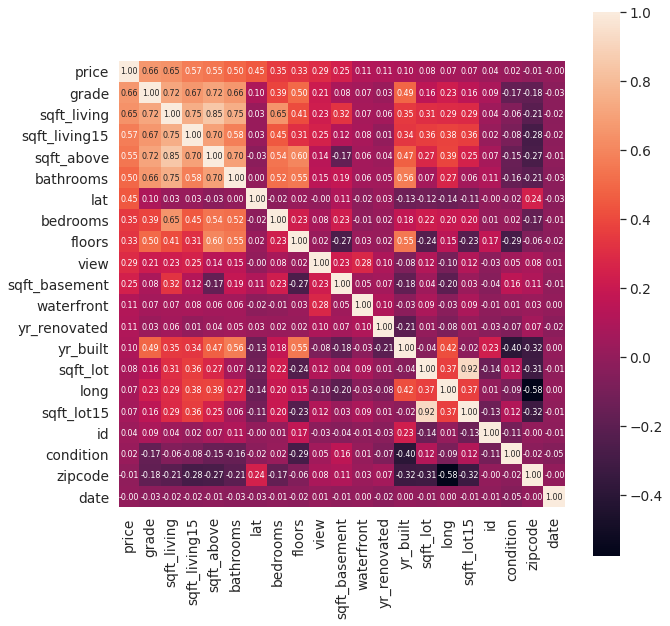

In [ ]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21,columns='price').index # 상위 10개 지정
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [ ]:
train.zipcode[:10]

0    98178
1    98028
2    98074
3    98003
4    98198
5    98007
6    98115
7    98028
8    98074
9    98107
Name: zipcode, dtype: int64

- target data인 price 처리

In [ ]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- id 컬럼 삭제

In [ ]:
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
train.describe()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,1438.545993,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,44.252050,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,1405.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,1407.000000,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,1410.000000,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,1502.000000,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,1505.000000,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [ ]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


- test data도 똑같이 전처리 해줍니다.
    - 단 price는 없음 

In [ ]:
test['date'] = test['date'].apply(lambda i: i[2:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- target data 전처리

In [ ]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

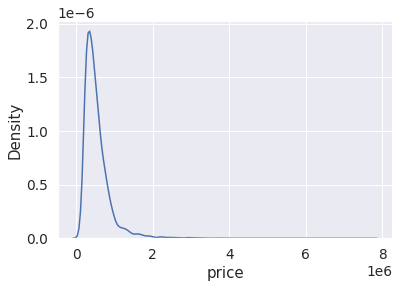

In [ ]:
sns.kdeplot(y)
plt.show()

- 분포와 price값 스케일이 크다.
- 왼쪽으로 치우쳐져있는 price를 로그 변환처리해준다.

In [ ]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

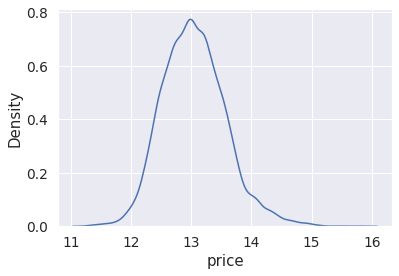

In [ ]:
sns.kdeplot(y)
plt.show()

- 데이터의 스케일이 작아졌고, 분포도 정규분포와 비슷한 형태로 바뀌었다. 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 02. build and train model
- 하이퍼 파라미터 조정을 위한 함수 생성

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  # np.expml : 원래 스케일로 되돌리기

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
random_state=1028

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [ ]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 124131.19692815996,
 'XGBRegressor': 106615.63530702426,
 'LGBMRegressor': 107257.79913572696,
 'RandomForestRegressor': 134623.62574778864}

- 위의 과정을 함수로 생성

In [ ]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,134623.625748
GradientBoostingRegressor,124131.196928
LGBMRegressor,107257.799136
XGBRegressor,106615.635307


## 03. tune hyperparameter
- 그리드 탐색

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 11], 
    'gamma': [0.5, 0.7, 0.3],
    'learning_rate': [0.029, 0.03],
    'boosting':["gbdt"],
    'num_iteration': [2500, 3000],
    "num_leaves" :[18, 19, 20],
    "objective" : ["regression"],
    "bagging_freq":[1],
    "bagging_fraction":[0.7, 0.8, 0.9]
}

In [ ]:
model = LGBMRegressor(random_state=random_state)
# model = XGBRegressor(random_state=random_state)

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.1min


In [ ]:
import sklearn
sklearn. __version__ 

**keyerror base_score**   
    : sklearn version 0.23.0 -> 0.23.1로 업그레이드 후 해결   
- 결과 확인

In [ ]:
grid_model.cv_results_

In [ ]:
params = grid_model.cv_results_['params']
params

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

In [ ]:
results = pd.DataFrame(params)
results['score'] = score

results

- **최적화된 하이퍼 파라미터**

In [ ]:
grid_model.best_params_

In [ ]:
results['RMSLE'] = np.sqrt(-1 * results['score'])
results

- RMSLE를 기준으로 정렬

In [ ]:
results = results.sort_values('RMSLE')
results[:10]

- 그리드 탐색을 통해, 최적의 하이퍼 파라미터를 알 수 있었다.(lgb, xgboost)
    - gamma = 0.5
    - learning rate = 0.05
    - max depth = 10
    - n_estimators = 100
    
## 04. 함수로 튜닝하면서 학습하기

In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
model = LGBMRegressor(random_state=random_state, n_estimators=100,
    max_depth=11, 
    gamma=0.7,
    learning_rate=0.029,
    boosting="gbdt",
    num_iteration=2500,
    objective="regression",
    num_leaves=20,
     bagging_freq=1,
    bagging_fraction=0.9)
# model = XGBRegressor(max_depth=10, n_estimators=100, random_state=random_state)

# model.fit(train, y)
# prediction = model.predict(test)
# prediction

- 로그변환했던 것을 되돌려서 원래 스케일로 만들기

In [ ]:
prediction = np.expm1(prediction)
prediction

In [ ]:
data_dir = os.getenv('HOME')+'/Projects/Project_Aiffel/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

- sample 프레임에 학습으로 예측한 값을 붙여주기

In [ ]:
submission['price'] = prediction
submission.head()

In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.160072')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

In [ ]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/Projects/Project_Aiffel/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.159458')

## 05. 캐글 제출, 스코어 확인
---
![exp9_score](https://user-images.githubusercontent.com/68461606/108395270-f6e7b180-7258-11eb-8323-d2ac511bb821.png)


# 정리     
---        
1. 데이터 준비와 전처리
    - target data 분리
    - 불필요한 데이터 삭제
    - 정수형 데이터로 변환
    - 데이터 분포, 연관성 확인
2. 하이퍼 파라미터 튜닝
    - 그리드 서치를 이용해서 가장 잘 학습된 하이퍼 파라미터를 확인
3. 제출 파일 생성



# 루브릭 평가
---
1. **캐글 데이터분석 전과정이 성공적으로 진행되었는가?**   
    - 하이퍼 여러 파라미터 튜닝을 시도


2. **전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?**  
    - 전체 흐름은 간략하게 서술했으며, 시각화를 히트맵으로 시도
    
     
3. **회귀모델 예측정확도가 기준 이상 높게 나왔는가?**  
    - 110294.34489 점을 달성

    
# 회고
---
## 어려웠던 점 
- 데이터 앙상블을 하지 못했다
    
    
## 알게된 점 
- low, high model
    - 트리 탐색을 이용한 모델들의 경우, 튜닝할 수 있는 하이퍼 파라미터에 따라 low, medium, high 모델로 나눌 수 있다.
    
    
## 더 공부할 점
- feature encoding
    - 다른 프로젝트를 할 때 모든 feature에 대해 label 혹은 one hot 인코딩을 했는데, 아이펠 노드에서는 자주 보지 못한 것 같다. regression에서는 잘 사용되지 않는 건지 더 공부해봐야겠다.
- 모델에 대한 이해
    - 모델에 대한 공부 없이 파라미터에 대해서만 간략히 공부 후 적용하려니 단순 반복과 감에 의존해야했던 점이 어려웠다.
    - 캐글에서 좋은 점수를 얻을 수 있는 모델들에 대해서도 구조를 공부해야겠다.
    
    
## 시도한 것들
- 혼자 해결하기 어려운 점이 많았어서, 깃헙에 있는 선배들의 코드를 참고했다.

- 하이퍼 파라미터 튜닝
    - n_estimators, max_depth, gamma, learning_rate, boosting, num_iteration, objective, num_leaves, bagging_freq, bagging_fraction 
    - 여러 파라미터로 다양한 시도를 함
    - 스케일을 넓게 잡고 그 안에서 더 작은 스케일로 그리드 탐색을 함 
    
    
## 지표 달성하지 못한 이유
- 앙상블을 못한점, 그리고 데이터 전처리를 다양하게 하지 못했고,하이퍼 파라미터 튜닝에만 힘을 썼다. 좀더 지표에 가까운 점수를 만들어낼 수 있었지만, 앙상블을 더 했으면 좋았을 것 같다. xgboost는 너무 시간이 오래걸리고, 스코어가 매우 낮기 때문에 light bgm으로 선택했다. 탐색 깊이(하이퍼 파라미터)에 따라 low, high 모델로 나뉜다는 것을 알았기 때문에 파라미터를 나누어서 앙상블하면 결과가 어떨지 궁금하다.




## 다짐
- 데이터를 파고드는 연습이 필요하다.